In [1]:
import sys
import os
import subprocess
from math import *
import numpy as np
from datetime import *
from pylab import *
import matplotlib as mpl
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
from astropy.table import Table, Column 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import scipy.misc as scimisc
import random

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
data = np.load('/content/drive/My Drive/data_64x64.npz')
images_ = data['images']
labels_ = data['labels'] 
data.close() 

51


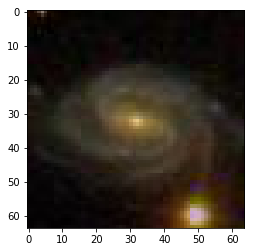

In [3]:
i = 750
print labels_[1][i]
plt.imshow(images_[i])

(array([3220., 2460., 2532., 3296., 3188., 4936., 4940., 5692., 5208.,
        7552.]),
 array([51. , 54.9, 58.8, 62.7, 66.6, 70.5, 74.4, 78.3, 82.2, 86.1, 90. ]),
 <a list of 10 Patch objects>)

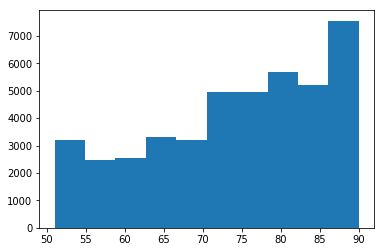

In [4]:
plt.hist(labels_[1][labels_[1]>50])

(60468, 64, 64, 3)
(43024, 64, 64, 3)
65


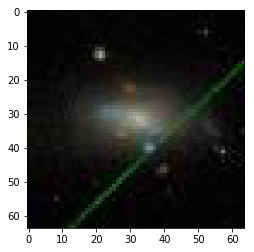

In [5]:
print images_.shape
ix, = np.where(labels_[1]>50)

images_c = images_[ix]
labels_c = labels_[1][ix]
pgcIDs_c = labels_[0][ix]

print images_c.shape

i = 100
plt.imshow(images_c[i])
print labels_c[i]


In [6]:
print(len(set(labels_c)))
print np.min(labels_c)
print np.max(labels_c)


40
51
90


In [7]:
def esn_shuffle(array, seed=0):
        random.seed(seed)
        random.shuffle(array)
        return array

In [8]:
n = len(labels_c)

indices = np.arange(n)
indices = esn_shuffle(indices, seed=0)


images_cc = images_c[indices]
labels_cc = labels_c[indices]
pgcIDs_cc = pgcIDs_c[indices]

#################

indices = np.arange(1000)
images_test  = images_cc[indices]
labels_test  = labels_cc[indices]
pgcIDs_test  = pgcIDs_cc[indices]

################# 

indices = np.arange(1000, n)
images_train = images_cc[indices]
labels_train = labels_cc[indices]
pgcIDs_train = pgcIDs_cc[indices]


ibx = np.logical_not(np.isin(pgcIDs_train, pgcIDs_test))
images_train = images_train[ibx]
labels_train = labels_train[ibx]
pgcIDs_train = pgcIDs_train[ibx]

#################
# Taking only unique galxies in the test set
# This is the brute-force approach.
# I need to make this better in the future

unique_IDs = []
unique_inx = []

for i, id in enumerate(pgcIDs_test):
    if not id in unique_IDs:
        unique_IDs.append(id)
        unique_inx.append(i)
        
        
images_test  = images_test[unique_inx]
labels_test  = labels_test[unique_inx]
pgcIDs_test  = pgcIDs_test[unique_inx]

In [9]:
print images_train.shape , labels_train.shape
print images_test.shape , labels_test.shape


(39180, 64, 64, 3) (39180,)
(961, 64, 64, 3) (961,)


(array([ 66.,  63.,  51.,  72.,  72., 123., 102., 128., 128., 156.]),
 array([51. , 54.9, 58.8, 62.7, 66.6, 70.5, 74.4, 78.3, 82.2, 86.1, 90. ]),
 <a list of 1 Patch objects>)

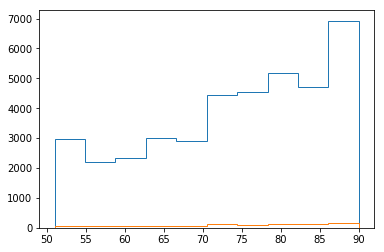

In [10]:
plt.hist(labels_train, histtype='step', label='train')
plt.hist(labels_test, histtype='step', label='test')

In [11]:
print labels_train

[62 58 88 ... 69 83 86]


In [12]:
labels_train  = labels_train - 51
labels_test   = labels_test - 51
images_test   = images_test / 255.
images_train  = images_train / 255.

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

import numpy as np
def vgg6(input_shape=(64, 64, 3), n_classes= 40):
    """
        VGG6
    :param input_shape:
    :param n_classes:
    :return:
    """

    model = tf.keras.models.Sequential(name='VGG6')
    # input: 21x21 images with 1 channel -> (21, 21, 1) tensors.
    # this applies 16 convolution filters of size 3x3 each.
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', name='conv2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv3'))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv4'))
    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu', name='fc_1'))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Dense(128, activation='relu', name='fc_2'))
    model.add(tf.keras.layers.Dropout(0.25))
    
    # output layer
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))

    return model

In [14]:
vgg_model = vgg6()
vgg_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
n_epochs=30
vgg_model.summary()
vgg_model_history = vgg_model.fit(images_train, labels_train, 
                                  epochs=n_epochs, batch_size=512, verbose=2, 
                                  validation_split=0.2,
                                  shuffle=True)


Model: "VGG6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 62, 62, 16)        448       
_________________________________________________________________
conv2 (Conv2D)               (None, 60, 60, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 16)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 28, 28, 32)        4640      
_________________________________________________________________
conv4 (Conv2D)               (None, 26, 26, 32)        9248      
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 26, 26, 32)        128    

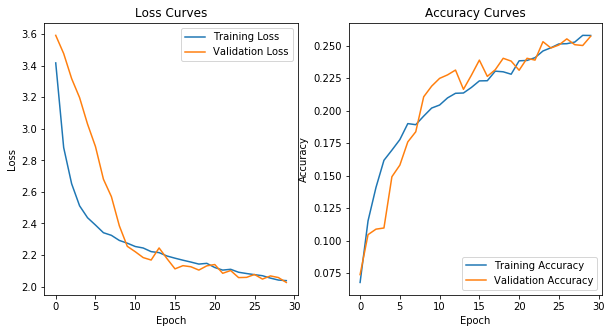

In [15]:
def plot_model_history(history):
    '''Plot the training and validation history for a TensorFlow network'''

    # Extract loss and accuracy
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
    ax[0].plot(np.arange(n_epochs), loss, label='Training Loss')
    ax[0].plot(np.arange(n_epochs), val_loss, label='Validation Loss')
    ax[0].set_title('Loss Curves')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(n_epochs), acc, label='Training Accuracy')
    ax[1].plot(np.arange(n_epochs), val_acc, label='Validation Accuracy')
    ax[1].set_title('Accuracy Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    
# plot the training history
# print vgg_model.history.history['loss']

plot_model_history(vgg_model.history)
  

In [16]:
inc_p = vgg_model.predict(images_test)
inc_m = labels_test +51


N = images_test.shape[0]

inc_p = np.argmax(inc_p, axis=1) + 51

72
68


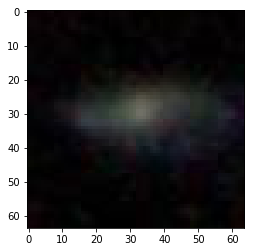

In [17]:
i = 90
print inc_p[i]
print inc_m[i]
plt.imshow(images_test[i])

In [18]:
def metrics(y1, y2):
    '''
    y1 and y2 are two series of the same size

    This function outputs the MAE, RMSE and R^2 
    of the cross evaluated series.

    '''
    y1 = y1.reshape(-1)
    y2 = y2.reshape(-1)
    RMSE = np.sqrt(np.mean((y1-y2)**2))
    MAE = np.mean(np.abs(y1-y2))

    print('MAE: %.3f'%MAE, ' RMSE: %.3f'%RMSE)
########################################

('MAE: 2.087', ' RMSE: 3.630')


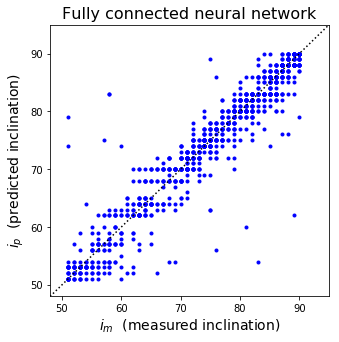

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    
ax.plot(inc_m, inc_p, '.', color='b')
ax.plot([48,95],[48,95], 'k:')
ax.set_xlim(48,95)
ax.set_ylim(48,95)
ax.set_title('Fully connected neural network', fontsize=16)
ax.set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax.set_ylabel(r'$i_p$'+'  (predicted inclination)', fontsize=14)

metrics(inc_p, inc_m)

In [24]:
vgg_model.save("/content/drive/My Drive/CNN_inc_VGG6_classify.h5")
print("Saved model to disk")

Saved model to disk
